# Minplus algebra experiment

This code attempts to learn the 64D mixture prior
$J(x) = min(\frac{1}{2t\sigma_{1}}||x-\mu_{1}||^{2}, \frac{1}{2\sigma_{2}}||x-\mu_{2}||^{2})$
assuming we have access to training data $\{y_i, S(y_i)\} = min_{x \in \R} \ \{0.5||x-y_i||^{2}_{2} + J(x)\}\}$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/minplus_64D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the solution S(y,t) of the Hamilton--Jacobi
    PDE for the minplus algebra example at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        hjsol:  An n-dimensional numpy array of numbers
    '''

    val1 = 0.5*pow(euclid_norm(y-mu1),2)/(1+sigma1)
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/(1+sigma2)
    hjsol = np.minimum(val1,val2)
    return hjsol


def prior_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the initial data of the Hamilton--Jacobi
    PDE for the minplus algebra example.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        prior:  An n-dimensional numpy array of numbers
    '''
        
    val1 = 0.5*pow(euclid_norm(y-mu1),2)/sigma1
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/sigma2
    prior = np.minimum(val1,val2)
    return prior


def cvx_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes 0.5*norm(y)_{2}^{2} - S(y,t) at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        cvx:  An n-dimensional numpy array of numbers
    '''

    cvx = 0.5*pow(euclid_norm(y),2) - hjsol_true(y,mu1,mu2,sigma1,sigma2)
    return cvx


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_cvx_true = cvx_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    x1_0_prior_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_prior_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.subplots()
    plt.plot(xi, x1_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x1_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the convex function")
    plt.xlabel('$x_1$')
    plt.ylabel('Convex functions ($x_1$,0)')
    plt.legend()

    plt.subplots()
    plt.plot(xi, x2_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x2_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the convex function")
    plt.xlabel('$x_2$')
    plt.ylabel('Convex functions (0, $x_2$)')
    plt.legend()

    # Plot cross sections of the prior function
    plt.subplots()
    plt.plot(xi, x1_0_prior_est, "-", label="LPN")
    plt.plot(xi, x1_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the prior function")
    plt.xlabel('$x_1$')
    plt.ylabel('Prior functions ($x_1$,0)')
    plt.legend()

    plt.subplots()
    plt.plot(xi, x2_0_prior_est, "-", label="LPN")
    plt.plot(xi, x2_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the prior function")
    plt.xlabel('$x_2$')
    plt.ylabel('Prior functions (0, $x_2$)')
    plt.legend()




def plot_all(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 64

# Prior parameters
mu1 = np.zeros(dim); mu1[0] = 1.0;  sigma1 = 1.0
mu2 = np.ones(dim)/np.sqrt(dim);    sigma2 = 1.0

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 40000
Iterations = 500000

# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 10       # beta of softplus
hidden = 200     # number of hidden units
layers = 4      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,mu1,mu2,sigma1,sigma2).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-3
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 7396.96142578125
iteration 0 loss 73404.1875


iteration 5000 loss 6.943220138549805


iteration 10000 loss 0.07389900833368301


iteration 15000 loss 0.019984478130936623


iteration 20000 loss 0.018955031409859657


iteration 25000 loss 0.027010563760995865


iteration 30000 loss 0.008014588616788387


iteration 35000 loss 0.015320212580263615


iteration 40000 loss 0.006878204178065062


iteration 45000 loss 0.01105892937630415


iteration 50000 loss 0.007350166328251362


iteration 55000 loss 0.05777532979846001


iteration 60000 loss 0.005719995126128197


iteration 65000 loss 0.7273688316345215


iteration 70000 loss 0.018561391159892082


iteration 75000 loss 0.015863468870520592


iteration 80000 loss 0.020307369530200958


iteration 85000 loss 0.005362782161682844


iteration 90000 loss 0.003804996842518449


iteration 95000 loss 0.01954840123653412


Learning rate decreased to 0.0001 at iteration 100000


iteration 100000 loss 0.011248469352722168


iteration 105000 loss 0.00020795082673430443


iteration 110000 loss 1.3411813597485889e-05


iteration 115000 loss 2.7468213374959305e-06


iteration 120000 loss 7.777784958307166e-07


iteration 125000 loss 4.538970460998826e-05


iteration 130000 loss 3.031906032902043e-07


iteration 135000 loss 0.0008563574519939721


iteration 140000 loss 0.002424501581117511


iteration 145000 loss 2.693294618438813e-07


iteration 150000 loss 2.246049177756504e-07


iteration 155000 loss 3.586696379898058e-07


iteration 160000 loss 8.42805718548334e-07


iteration 165000 loss 3.9349322378257057e-07


iteration 170000 loss 0.0023377893958240747


iteration 175000 loss 0.0012007809709757566


iteration 180000 loss 2.1329717583284946e-06


iteration 185000 loss 0.002529588993638754


iteration 190000 loss 2.3978324747986335e-07


iteration 195000 loss 1.655661799304653e-05


Learning rate decreased to 1e-05 at iteration 200000


iteration 200000 loss 1.8226498355033982e-07


iteration 205000 loss 3.798723113845881e-08


iteration 210000 loss 5.074649589431601e-09


iteration 215000 loss 3.5947400647273753e-06


iteration 220000 loss 1.122074877457635e-09


iteration 225000 loss 1.8247034994089972e-09


iteration 230000 loss 5.735353303393254e-10


iteration 235000 loss 0.0003059984010178596


iteration 240000 loss 7.9391972163112e-11


iteration 245000 loss 7.423040654375157e-11


iteration 250000 loss 9.599316480590758e-11


iteration 255000 loss 1.7079599274438806e-05


iteration 260000 loss 1.9101640646113083e-05


iteration 265000 loss 8.03887789668778e-11


iteration 270000 loss 1.1579674996653466e-09


iteration 275000 loss 1.2506809810020059e-07


iteration 280000 loss 1.402462590505138e-10


iteration 285000 loss 2.9972466109029483e-06


iteration 290000 loss 6.848640404788497e-11


iteration 295000 loss 2.3975530893949326e-08


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000


iteration 300000 loss 1.6296426963435806e-07


iteration 305000 loss 1.3444077795465859e-10


iteration 310000 loss 3.3789183256915933e-11


iteration 315000 loss 8.16190337538103e-10


iteration 320000 loss 1.370070390471767e-09


iteration 325000 loss 2.8013162969853234e-11


iteration 330000 loss 3.056666031397981e-11


iteration 335000 loss 3.1534361927265664e-11


iteration 340000 loss 3.539225856830086e-10


iteration 345000 loss 8.192255207539745e-11


iteration 350000 loss 6.687769088520312e-11


iteration 355000 loss 3.6375059214721617e-11


iteration 360000 loss 1.0336493687645998e-06


iteration 365000 loss 3.1627495761243907e-11


iteration 370000 loss 1.0361145275084027e-10


iteration 375000 loss 2.7479471823022017e-11


iteration 380000 loss 2.684901086180691e-11


iteration 385000 loss 2.7502390989586623e-11


iteration 390000 loss 6.139449504338756e-10


iteration 395000 loss 2.7906206859218408e-11


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000


iteration 400000 loss 2.785200195476456e-11


iteration 405000 loss 2.6926134932825363e-11


iteration 410000 loss 2.598098819417416e-11


iteration 415000 loss 1.7431192600447787e-10


iteration 420000 loss 2.696724440975906e-11


iteration 425000 loss 2.714514203694396e-11


iteration 430000 loss 3.943641593839864e-11


iteration 435000 loss 2.7062196233940128e-11


iteration 440000 loss 4.8711444600169074e-11


iteration 445000 loss 2.6023917396034157e-11


iteration 450000 loss 2.6530323077311735e-11


iteration 455000 loss 2.80142558456431e-11


iteration 460000 loss 2.758242766132124e-11


iteration 465000 loss 2.642991554779872e-11


iteration 470000 loss 2.5774351403162754e-11


iteration 475000 loss 1.741867899918148e-10


iteration 480000 loss 2.6235283043241076e-11


iteration 485000 loss 2.7896749146827382e-11


iteration 490000 loss 2.656517505972289e-10


iteration 495000 loss 4.173780071559108e-11


L2 loss -- Plot

loss -40.68035888671875


loss -283.91009521484375


loss -406.181396484375


loss -497.9571228027344


loss -582.09326171875


loss -660.26171875


loss -731.7308349609375


loss -794.474853515625


loss -844.99365234375


loss -879.2091674804688


loss -897.61181640625


loss -906.69140625


loss -912.1644897460938


loss -915.719482421875


loss -917.939208984375


loss -919.2335205078125


loss -919.9301147460938


loss -920.272216796875


loss -920.4227905273438


loss -920.4805908203125


loss -920.4992065429688


loss -920.5039672851562


loss -920.5048217773438


loss -920.5049438476562


loss -920.5049438476562


loss -920.5049438476562


loss -920.5049438476562


loss -920.5049438476562


loss -920.5049438476562


loss -920.5049438476562


loss -920.5049438476562


loss -920.5049438476562


loss -920.5049438476562


loss -920.5049438476562


loss -920.5049438476562


loss -920.5049438476562


loss -920.5049438476562


loss -920.5049438476562


loss -920.5049438476562


loss -920.5049438476562


final mse:  1.5796620678187878e-09
max, min: 6.260982 -6.8806887
loss -40.68035888671875


loss -281.4242858886719


loss -403.8515319824219


loss -496.4999084472656


loss -581.3521728515625


loss -659.3727416992188


loss -729.9776611328125


loss -791.676513671875


loss -841.82568359375


loss -877.9864501953125


loss -900.8522338867188


loss -914.0755615234375


loss -922.060546875


loss -927.5404052734375


loss -931.4884033203125


loss -934.2742919921875


loss -936.147705078125


loss -937.3297119140625


loss -938.0183715820312


loss -938.380859375


loss -938.54833984375


loss -938.6135864257812


loss -938.6340942382812


loss -938.638916015625


loss -938.6397094726562


loss -938.6397705078125


loss -938.6397705078125


loss -938.6397705078125


loss -938.6397705078125


loss -938.6397705078125


loss -938.6397705078125


loss -938.6397705078125


loss -938.6397705078125


loss -938.6397705078125


loss -938.6397705078125


loss -938.6397705078125


loss -938.6397705078125


loss -938.6397705078125


loss -938.6397705078125


loss -938.6397705078125


final mse:  2.2689063960967815e-09
max, min: 7.2966957 -7.6552157


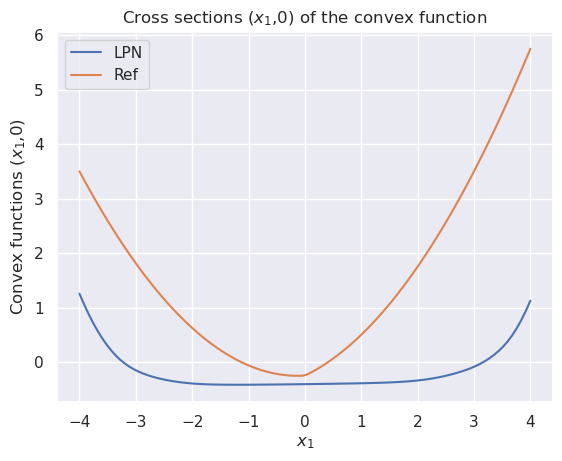

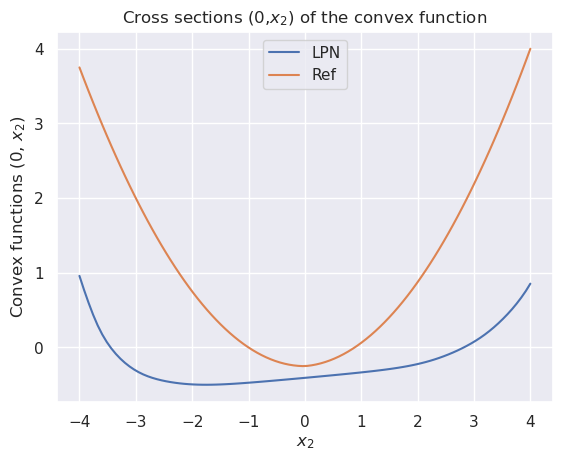

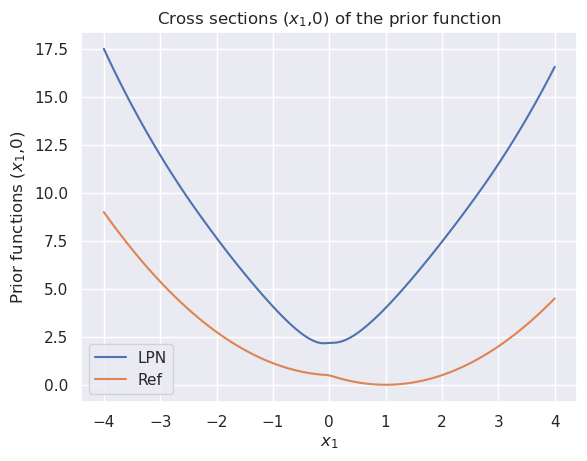

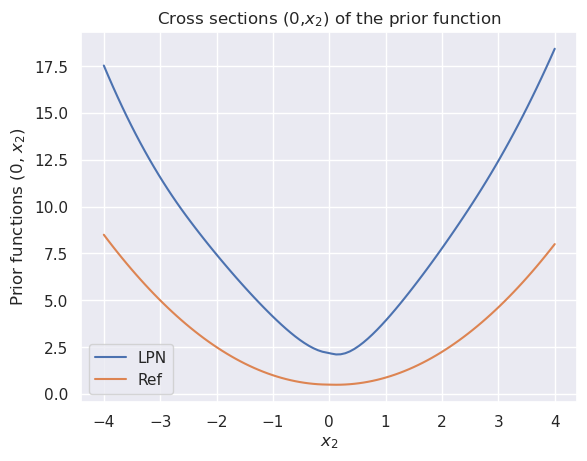

In [7]:
plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# 1. Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# 2. Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

# Detach the tensor to treat G_k as fixed targets, breaking the connection
# to the first LPN's graph and preventing the RuntimeError during training.
G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

# The input tensor x_k_tensor is still needed for the second LPN training,
# but it should also not require a gradient for that training.
x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)
# G_samples_tensor now holds the target values G_k
print(f"Generated G samples: G_samples_tensor shape {G_samples_tensor.shape}")

# --- Step 3: Train LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
# The target for this LPN is G_samples_tensor
# The input for this LPN is x_k_tensor
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-4)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-3 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")

Generated G samples: G_samples_tensor shape torch.Size([40000, 1])

--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 5531.29931640625
iteration 0 loss 8068.4111328125


iteration 5000 loss 0.5380712151527405


iteration 10000 loss 0.11979445815086365


iteration 15000 loss 0.05041864141821861


iteration 20000 loss 0.03487106412649155


iteration 25000 loss 0.02025921642780304


iteration 30000 loss 1.4430651664733887


iteration 35000 loss 1.2662761211395264


iteration 40000 loss 0.020988374948501587


iteration 45000 loss 0.14298132061958313


iteration 50000 loss 0.014263516291975975


iteration 55000 loss 0.2669914960861206


iteration 60000 loss 0.006722751539200544


iteration 65000 loss 0.007541224360466003


iteration 70000 loss 0.014805302023887634


iteration 75000 loss 0.05292454734444618


iteration 80000 loss 0.03675830736756325


iteration 85000 loss 0.2226126343011856


iteration 90000 loss 0.07831095904111862


iteration 95000 loss 0.2876105010509491


Learning rate decreased to 0.0001 at iteration 100000


iteration 100000 loss 0.003649523016065359


iteration 105000 loss 0.0006966449436731637


iteration 110000 loss 0.00029855637694709003


iteration 115000 loss 0.0001526931009721011


iteration 120000 loss 8.725045336177573e-05


iteration 125000 loss 5.056571899331175e-05


iteration 130000 loss 3.133857171633281e-05


iteration 135000 loss 2.1745310732512735e-05


iteration 140000 loss 1.2024681382172275e-05


iteration 145000 loss 9.61172736424487e-06


iteration 150000 loss 0.0014747404493391514


iteration 155000 loss 3.988716798630776e-06


iteration 160000 loss 2.5641818865551613e-05


iteration 165000 loss 2.1947248569631483e-06


iteration 170000 loss 1.7996558199229185e-06


iteration 175000 loss 3.290048334747553e-05


iteration 180000 loss 0.0003105647920165211


iteration 185000 loss 9.762006811797619e-05


iteration 190000 loss 1.2869145393779036e-06


iteration 195000 loss 8.972469345280842e-07


Learning rate decreased to 1e-05 at iteration 200000


iteration 200000 loss 8.612269084551372e-07


iteration 205000 loss 0.0001696771796559915


iteration 210000 loss 2.2073768946029304e-07


iteration 215000 loss 4.360987531981664e-06


iteration 220000 loss 8.528916595196279e-08


iteration 225000 loss 6.791114515181107e-08


iteration 230000 loss 4.526195596099569e-08


iteration 235000 loss 3.8998233975462426e-08


iteration 240000 loss 3.053996877611098e-08


iteration 245000 loss 2.4865293823950196e-08


iteration 250000 loss 2.1501389113609548e-08


iteration 255000 loss 1.9174260401655374e-08


iteration 260000 loss 1.618780309797785e-08


iteration 265000 loss 1.3014961552926252e-08


iteration 270000 loss 1.3013905508785228e-08


iteration 275000 loss 1.223452272824943e-08


iteration 280000 loss 1.137115113181153e-08


iteration 285000 loss 1.1842621994162528e-08


iteration 290000 loss 8.201598511448083e-09


iteration 295000 loss 8.096093573328744e-09


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000


iteration 300000 loss 6.5232539370185805e-09


iteration 305000 loss 5.870129715646044e-09


iteration 310000 loss 4.3541836802774014e-09


iteration 315000 loss 3.4458671471782054e-09


iteration 320000 loss 2.869780857395199e-09


iteration 325000 loss 2.3882089639215565e-09


iteration 330000 loss 2.1769945846017436e-09


iteration 335000 loss 1.839397745229121e-09


iteration 340000 loss 1.7205503688444423e-09


iteration 345000 loss 1.5275188891550329e-09


iteration 350000 loss 1.4013173954552371e-09


iteration 355000 loss 1.3165925016878077e-09


iteration 360000 loss 1.2292616924369781e-09


iteration 365000 loss 1.0039635789382828e-09


iteration 370000 loss 1.0424525687113828e-09


iteration 375000 loss 1.038468644409818e-09


iteration 380000 loss 8.299320675142496e-10


iteration 385000 loss 7.663049084172258e-10


iteration 390000 loss 7.134123292118488e-10


iteration 395000 loss 8.204645851606074e-10


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000


iteration 400000 loss 8.23911217029405e-10


iteration 405000 loss 7.644011534857498e-10


iteration 410000 loss 5.979327033500681e-10


iteration 415000 loss 5.412191805831412e-10


iteration 420000 loss 5.06275299461123e-10


iteration 425000 loss 4.744818982160837e-10


iteration 430000 loss 4.5469786269514145e-10


iteration 435000 loss 4.278612186769948e-10


iteration 440000 loss 4.0521225264100735e-10


iteration 445000 loss 3.8771685861860306e-10


iteration 450000 loss 3.672696036183254e-10


iteration 455000 loss 3.606652199117377e-10


iteration 460000 loss 3.3881442096372894e-10


iteration 465000 loss 3.2351016310272485e-10


iteration 470000 loss 3.171706230986615e-10


iteration 475000 loss 3.007560589463054e-10


iteration 480000 loss 2.9979746463126844e-10


iteration 485000 loss 2.826527623067676e-10


iteration 490000 loss 2.7018612347440296e-10


iteration 495000 loss 2.650285546579312e-10


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


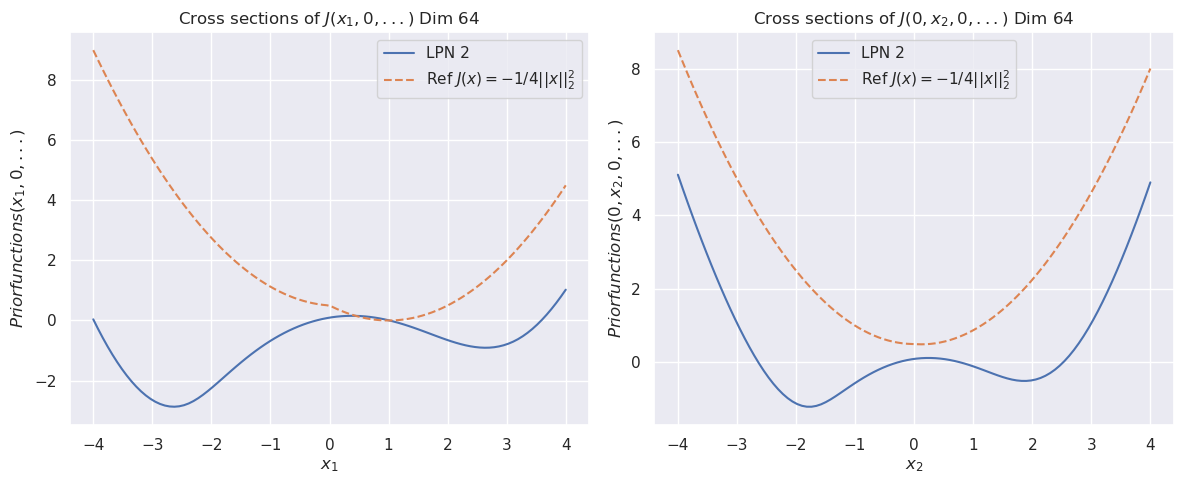

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    # Get G(x) from the second LPN model
    G_x = model_G.scalar(x_tensor)
    
    # Compute 0.5 * ||x||^2
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    # Apply the formula: J_est = G(x) - 0.5 * ||x||^2
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim,mu1,mu2,sigma1,sigma2):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)
    else:
        x2_0_J_true = x1_0_J_true
        
    # Estimated Prior from G(x) Network
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Prior functions (x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Prior functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    #plt.savefig('G_network_prior_plot.png')
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim,mu1,mu2,sigma1,sigma2)